In [1]:
# Load the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2
from tqdm import tqdm
import time
import joblib
from sklearn.metrics import accuracy_score,f1_score,classification_report
import os
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [35]:
labels = [ 'Scheherazade New' , 'Marhey' , 'Lemonada' , 'IBM Plex Sans Arabic']
image_size = 600

def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [36]:
# Load the images from fonts-dataset folder
def load_images():
    # Load the images from the fonts-dataset folder
    images_train = []
    labels_train = []
    # Use tqdm to show a progress bar
    for i in tqdm(labels):
        for filename in os.listdir(f'fonts-dataset/{i}'):
            img = cv2.imread(f'fonts-dataset/{i}/{filename}', cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (image_size, image_size))
            images_train.append(img)
            labels_train.append(i)
    return images_train, labels_train



In [38]:
# Load the images
X_train, y_train = load_images()
# Change the y_train to numbers
y_train = [labels.index(i) for i in y_train]

100%|██████████| 4/4 [00:25<00:00,  6.46s/it]


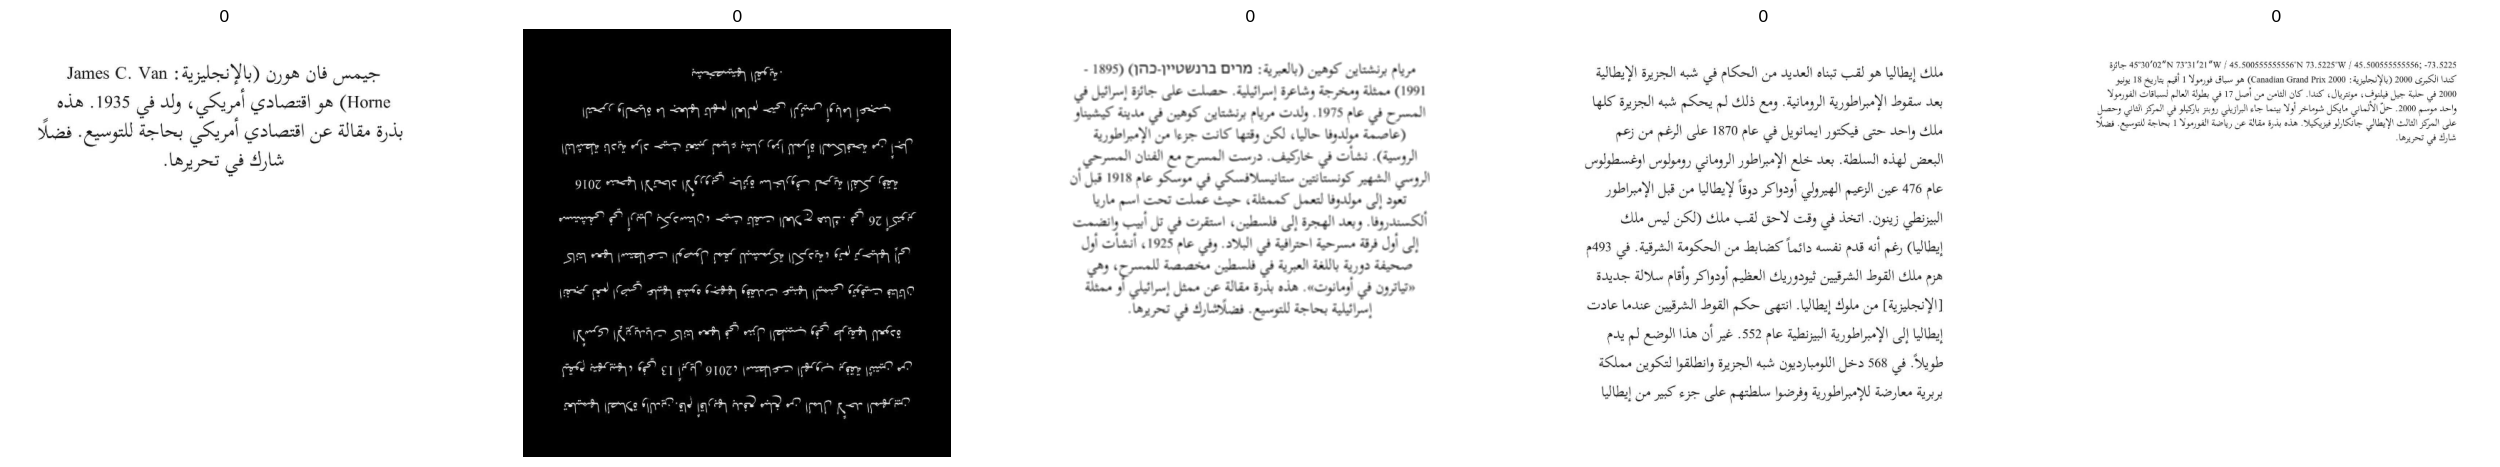

[0 0 0 0 0]


In [39]:
# Change to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
# Show the first 5 images
show_images(X_train[:5], titles=y_train[:5])
# Show y_train values
print(y_train[:5])

In [41]:
# Apply hog for the images
from skimage.feature import hog

X_train_hog = []
for i in tqdm(X_train):
    X_train_hog.append(hog(i, orientations= 8, pixels_per_cell=(32, 32), cells_per_block=(4, 4), block_norm='L2-Hys'))
    
    
# Print the shape of the hog features
print(X_train_hog[0].shape)

# # Try hog on one image
# hog_image = hog(X_train[0], orientations= 8, pixels_per_cell=(32, 32), cells_per_block=(4, 4), block_norm='L2-Hys')
# print(hog_image.shape)

100%|██████████| 4000/4000 [02:27<00:00, 27.09it/s]

4000


In [42]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_hog, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [43]:
# Apply Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train)
X_test_features = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

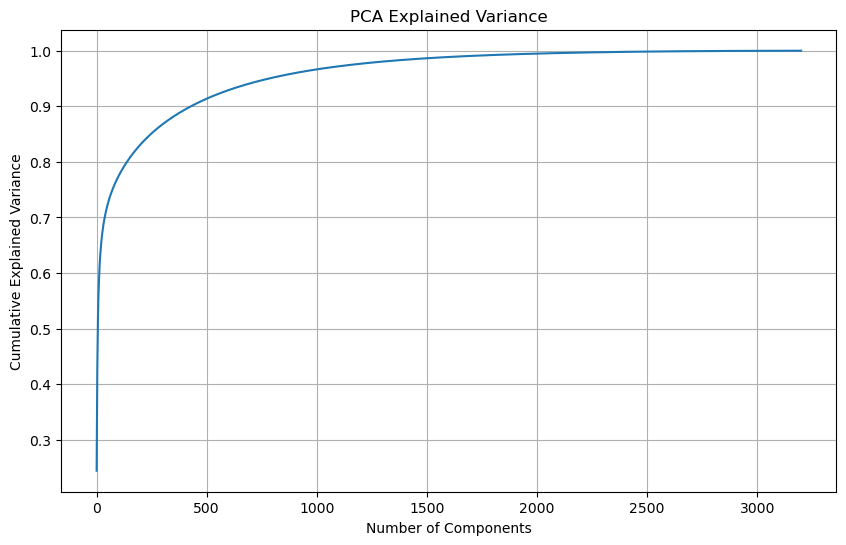

Number of components for 99% explained variance: 1663


In [44]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA()

# Fit PCA on the DataFrame
pca.fit(X_train_features)

# Calculate cumulative sum of explained variances
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative variance against the number of components
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


# Find the number of components for desired explained variance '99%''
n_components = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Number of components for 99% explained variance: {n_components}")

In [45]:
# Apply PCA to the HOG feature vectors
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_features)

# Apply PCA to the HOG feature vectors
X_test_pca = pca.transform(X_test_features)

# Save the PCA model as h5 file
joblib.dump(pca, 'pca_model.pkl')

['pca_model.pkl']

In [46]:
# Dump the X_train_hog into a pickle file within a folder named data_pickles
with open('./data_pickles/X_train_pca.pkl', 'wb') as f:
    pickle.dump(X_train_pca, f)
    
# Dump the X_test_hog into a pickle file
with open('./data_pickles/X_test_pca.pkl', 'wb') as f:
    pickle.dump(X_test_pca, f)
    
# Dump the y_train into a pickle file
with open('./data_pickles/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
    
# Dump the y_test into a pickle file
with open('./data_pickles/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [47]:
# Load the x_train_pca and x_test_pca
with open('./data_pickles/X_train_pca.pkl', 'rb') as f:
    X_train_pca = pickle.load(f)
    
with open('./data_pickles/X_test_pca.pkl', 'rb') as f:
    X_test_pca = pickle.load(f)
    
# Load the y_train
with open('./data_pickles/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
    
# Load the y_test
with open('./data_pickles/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [49]:

# Initialize the model
# {'warm_start': True, 'solver': 'saga', 'penalty': 'l2', 'C': 0.001}
model = LogisticRegression(warm_start=True, solver='saga', penalty='l2', C=0.01)

# Fit the model
model.fit(X_train_pca, y_train)

# Predict the test data
y_pred = model.predict(X_test_pca)

# Predict the train data
y_pred_train = model.predict(X_train_pca)

# Print the training accuracy
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train)}")

# Print the testing accuracy
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")

# Print the f1 score of the training data
print(f"Training F1 Score: {f1_score(y_train, y_pred_train, average='weighted')}")

# Print the f1 score of the testing data
print (f"Testing F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

# Print the classification report of the training data
print(classification_report(y_train, y_pred_train))

# Print the classification report of the testing data
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(model, 'logistic_model.pkl')

Training Accuracy: 0.9978125
Testing Accuracy: 0.8225
Training F1 Score: 0.9978130782436014
Testing F1 Score: 0.8214822799305677
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800
           2       1.00      1.00      1.00       800
           3       1.00      0.99      1.00       800

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       200
           1       0.82      0.82      0.82       200
           2       0.91      0.95      0.93       200
           3       0.83      0.71      0.77       200

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [55]:
# Initialize the SVM model
svm = SVC(C=0.1, degree=2, gamma='auto', kernel='poly', probability=True)

# Fit the SVM on the training data
svm.fit(X_train_pca, y_train)

# Predict the labels of the test set
y_pred = svm.predict(X_test_pca)
# Predict the labels of the training set
y_pred_train = svm.predict(X_train_pca)

# Print the accuracy of the SVM model on the training set
print(f"Accuracy of SVM model on the training set: {accuracy_score(y_train, y_pred_train)*100}")

# Print the accuracy of the SVM model on the test set
print(f"Accuracy of SVM model: {accuracy_score(y_test, y_pred)*100}")

# Print the classification report of the SVM model
print(classification_report(y_test, y_pred, target_names=labels))

# Print the classification report of the SVM model
print(classification_report(y_train, y_pred_train, target_names=labels))

# Save the SVM model as h5 file
joblib.dump(svm, 'svm_model.h5')